In [2]:
%matplotlib inline
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
from gpflow.utilities import print_summary, set_trainable, deepcopy
from IPython.display import clear_output
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
# for reproducibility of this notebook:
tf.random.set_seed(42)

In [3]:
def run_adam(model, iterations, data):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    :param data: observed data set
    :return logf: model training loss
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(data)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    # Optimize variational parameters 
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            loss = -training_loss().numpy()
            logf.append(loss)
            clear_output(wait=True)
            print("iteration {}".format(step))
    return logf

In [4]:
def run_continuous_opt(
    old_model,
    new_model,
    data,
    Znew,
    Zold,
    optimizer = None,
    maxiter=1e3,
    compile=False,
):
    """
    Training loop for continuous loss function Lc

    :param old_model: GPflow model
    :param new_model: GPflow model
    :param data: observed data set
    :param Znew: inducing points of new_model
    :param Zold: inducing points of old_model
    :param optimizer: tf.optimizers or tf.keras.optimizers that updates variables by applying the
        corresponding loss gradients. Adam is a default optimizer with default settings.
    :param maxiter: maximum number of iterations
    :return step: iteration number
    :return LC: model continuous training loss at step
    """
    
    # Initialise optimizer and get continuous covariance matrix Kuu and mean mu_uu
    step = []
    Lc = []
    KL = []
    
    optimizer = tf.optimizers.Adam(learning_rate=0.0001) if optimizer is None else optimizer
    var_list = new_model.trainable_variables
    #Kuu, mu_uu = get_Kuu(old_model, Znew, Zold)
    
    def optimization_step():
        ''' Optimization step, returns model loss'''
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(var_list)
            # Calls elbo function which returns Lc, the continuous lower-bound and KL divergences
            Kuu, mu_uu = get_Kuu(old_model, Znew, Zold)
            f = elbo(new_model,old_model,data,Znew,Zold,Kuu,mu_uu)
            loss = -f[0]
            KL = f[1]
        grads = tape.gradient(loss, var_list)
        optimizer.apply_gradients(zip(grads, var_list))
        return loss, KL
    
    if compile:
        optimization_step = tf.function(optimization_step)

    # Optimize variational parameters
    for iter in range(int(maxiter)):
        loss, KLstep = optimization_step()
        if iter % 10 == 0:
            step.append(iter)
            Lc.append(loss)
            KL.append(KLstep)
            #clear_output(wait=True)
            #print("iteration {}".format(iter))
            
    return step, Lc, KL

In [5]:
@tf.function
def elbo(new_model,old_model,data,Znew,Zold,Kuu,mu_uu):
    
    """
    Function to compute continuous lower-bound Lc.
    
    :param new_model: GPflow model
    :param old_model: GPflow model    
    :param data: observed data set Dnew
    :param Znew: inducing points of new_model
    :param Zold: inducing points of old_model
    :param Kuu: continuous covariance matrix
    :param mu_uu: continuous mean
    :return LC: model continuous training loss at step
    :return KL: KL divergences of prior and posterior distributions
    """
    
    X, Y = data
    
    # get mean and variance of latent function at new data points
    f_mean, f_var = new_model.predict_f(X)
    var_exp = new_model.likelihood.variational_expectations(f_mean, f_var, Y)
    # compute variational expectation
    var_exp = tf.reduce_sum(var_exp)
    # get p(u_new|psi_old) and p(u_new,psi_new)
    Kold = old_model.kernel(Znew)
    Knew = new_model.kernel(Znew)
    
    q_mu = new_model.q_mu
    q_sqrt = new_model.q_sqrt
    
    # compute KL divergences with posterior variational params of new GP
    KL_q_pnew = get_KL(q_mu, q_sqrt, Knew)
    KL_q_pold = get_KL(q_mu, q_sqrt, Kold)
    KL_q_qold = get_KL(q_mu, q_sqrt, Kuu, mu_uu)
    
    # compute lower bound Lc
    Lc = var_exp - KL_q_pnew + KL_q_pold - KL_q_qold
    KL = [KL_q_pnew, KL_q_pold, KL_q_qold]
    
    return Lc, KL

In [6]:
def get_Kuu(old_model, Znew, Zold):
    
    """
    Function to compute the variational posterior mean and covariance matrix
    
    :param old_model: GPflow model
    :param Znew: inducing points of new_model
    :param Zold: inducing points of old_model
    :return Kuu: continuous covariance matrix
    :return mu_uu: continuous mean
    """
    
    K = old_model.kernel
    
    Kxx = K(Znew)
    Kxm = K(Znew, Zold)
    Kmm = K(Zold, Zold)
    
    RHS = tf.eye(len(Kmm), dtype= 'float64')
    chol = tf.linalg.cholesky((Kmm + 0.005*RHS))
    #Kmminv = tf.linalg.cholesky_solve(chol,RHS)
    
    #Kmminv = tf.linalg.inv(Kmm)       
    Kmx = tf.transpose(Kxm)
    L_u = old_model.q_sqrt
    S_old = tf.tensordot(L_u, tf.transpose(L_u),axes=1)[0,:,:,0] 
    A = S_old - Kmm
    B = tf.linalg.cholesky_solve(chol, A)
    C = tf.linalg.cholesky_solve(chol, Kmx)
        
    Kuu = (
            Kxx + 
            Kxm @ B @ C
            )
    
    #mu_uu = Kxm @ Kmminv @ old_model.q_mu
    mu_uu = Kxm @ tf.linalg.cholesky_solve(chol, old_model.q_mu)
    
    return Kuu, mu_uu

In [7]:
def get_KL(q_mu, q_sqrt, K, mu=None):
    
    """
    Function to compute KL divergences of given covariance matrix and posterior variational parameters
    
    :param q_mu: mean of variational posterior of new model
    :param q_mu: cholesky of the covariance of variational posterior of new model
    :param K: covariance matrix of p(u_new | . )
    :param mu: optional, mean of p(u_new | . )
    :return KL: KL divergence of given distributions
    """
    K = tf.linalg.cholesky(K+0.005*tf.eye(len(K), dtype='float64'))       
    if mu == None:
        pu = tfd.MultivariateNormalTriL(scale_tril=K)
    else:
        pu = tfd.MultivariateNormalTriL(mu[:,0], K)
        
    qu = tfd.MultivariateNormalTriL(q_mu[:,0],q_sqrt)    
    
    KL = tfd.kl_divergence(qu,pu)
    
    return KL

In [8]:
def plot_model(model, X, Y, title=""):
    plt.figure(figsize=(15,7))
    plt.scatter(X,Y,alpha=0.5,marker="x")
    Xt = np.linspace(0, max(X[:,0]), 100)[:, None]
    Yt, Yv = model.predict_y(Xt)
    _ = plt.plot(Xt, Yt, c="k")
    '''plt.fill_between(
        Xt[:, 0],
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
        )'''
    _ = plt.plot(Xt[:, 0], (Yt - 2 * Yv ** 0.5)[:, 0], c="#ffa01f")
    _ = plt.plot(Xt[:, 0], (Yt + 2 * Yv ** 0.5)[:, 0], c="#ffa01f")
    Z = model.inducing_variable.Z.value()
    plt.scatter(Z, np.zeros_like(Z), c="k")
    plt.title(title)
    
    return plt

In [9]:
def build_kernel(prev_model, N_add):
    new_model = gpflow.utilities.deepcopy(prev_model)
    
    N_prev = len(prev_model.inducing_variable.Z.value())
    N = N_prev + N_add
    
    old_points = prev_model.inducing_variable.Z.value()
    new_points = tf.random.uniform(shape=[N_add,1], dtype='float64',minval=0., maxval=2.)
    Znew = tf.concat([old_points,new_points], axis=0)
    new_model.inducing_variable.Z = gpflow.Parameter(Znew) 
    
    A = tf.linalg.diag(tf.ones([1,N], dtype='float64')).numpy()
    B = prev_model.q_sqrt.numpy()
    
    A[0, 0:N_prev, 0:N_prev] = B
    
    new_model.q_sqrt = gpflow.Parameter(A, transform = tfp.bijectors.FillTriangular())
    
    mu_zeros = tf.zeros([N_add,1], dtype='float64')
    old_mu = prev_model.q_mu.value()
    new_mu = tf.concat([old_mu,mu_zeros], axis=0)
    new_model.q_mu = gpflow.Parameter(new_mu)
    
    return new_model

Text(0.5, 1.0, 'True f(X)')

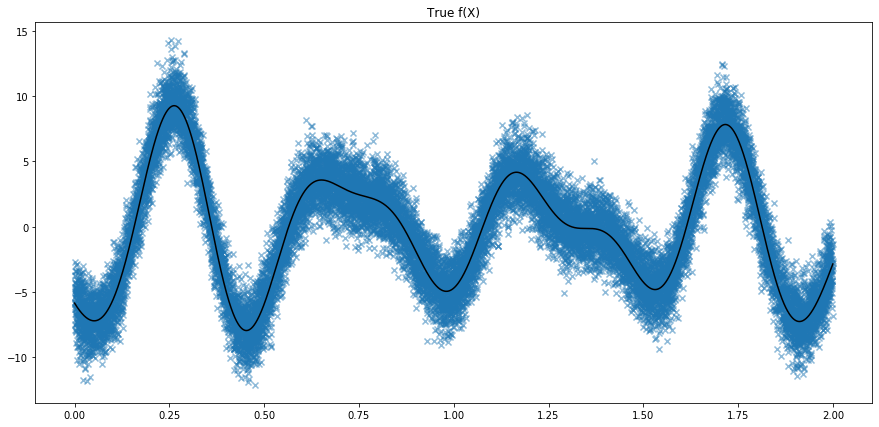

In [14]:
N = 20000
max_X = 2
X = np.sort(max_X*np.random.rand(N))[:, None]
def true_f(X_input):
    return (3 * np.cos(5 * np.pi * X_input + 1*np.pi) - \
           6 * np.sin(4.3 * np.pi * X_input + 0.3 * np.pi) + \
           2 * np.cos(7 * np.pi * X_input + 2 * np.pi))    

Y = np.random.normal(true_f(X),scale=1.5)

plt.figure(figsize=(15,7))
plt.scatter(X,Y, alpha=0.5,marker="x")
Xt = np.linspace(0, max_X, N)[:, None]
Yt = true_f(Xt)
_ = plt.plot(Xt, Yt, c="k")
plt.title("True f(X)")


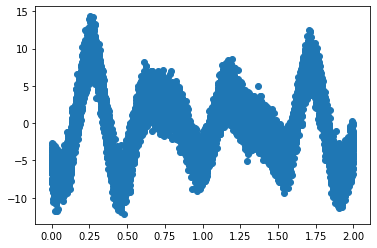

In [15]:
plt.scatter(X,Y)

In [16]:
n = 10  #num. batches
np.random.shuffle(X)
X_batched =  np.split(X,n)
Y_batched = np.empty_like(X_batched)
for i in range(len(X_batched)):
    Y_batched[i] = np.random.normal(true_f(X_batched[i]),scale=1.5)

Text(0.5, 1.0, 'True f(X)')

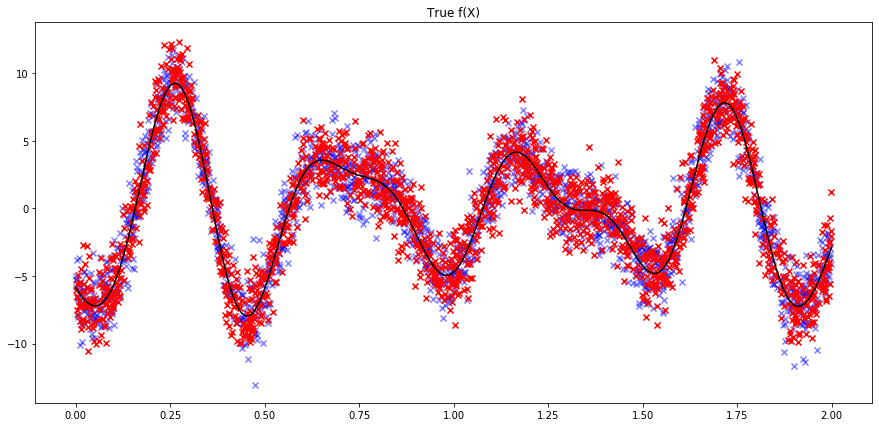

In [17]:
plt.figure(figsize=(15,7))
plt.scatter(X_batched[0],Y_batched[0], alpha=0.5,marker="x", color="b")
plt.scatter(X_batched[1],Y_batched[1], alpha=1,marker="x", color="r")
Xt = np.linspace(0, max_X, N)[:, None]
Yt = true_f(Xt)
_ = plt.plot(Xt, Yt, c="k", alpha=1)
plt.title("True f(X)")

In [18]:
# initialise inducing points and SVGP for first half of data
Zold = np.linspace(0,2,10)[:,None]
m_init = gpflow.models.SVGP(kernel = gpflow.kernels.SquaredExponential(),
                            likelihood = gpflow.likelihoods.Gaussian(), 
                            inducing_variable = Zold,
                            num_data = len(X_batched[0]))
#gpflow.set_trainable(m_old.inducing_variable, False)
m_init.kernel.lengthscales.assign(0.1)
#m_init.kernel.variance.assign(30)
m_init

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.10000000000000002
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(10, 1)",float64,[[0....
SVGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


<module 'matplotlib.pyplot' from 'C:\\Users\\ac1dmrx\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

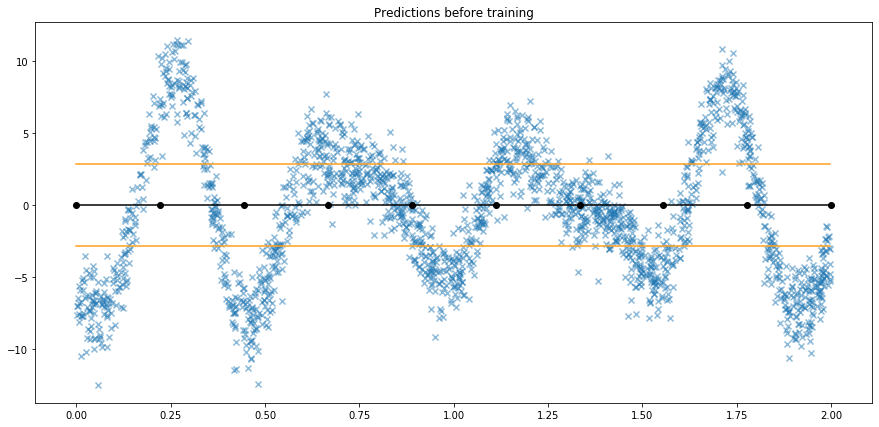

In [13]:
plot_model(m_init, X_batched[0], Y_batched[0], "Predictions before training")

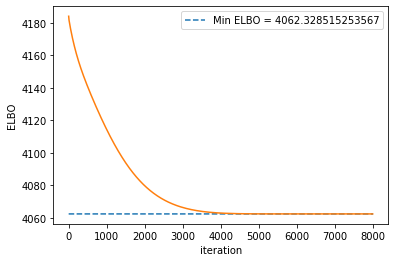

In [52]:
#data_old = (X_batched[0], Y_batched[0])
#logf = run_adam(m_init, 8000, data_old)
plt.plot(min(-1*np.array(logf))*np.ones(8000), linestyle='--', label='Min ELBO = {}'.format(min(-1*np.array(logf))))
plt.plot(np.arange(8000)[::10], -1*np.array(logf))
legend = plt.legend()
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [44]:
-1*np.array(logf)

array([4183.9969791 , 4181.5466267 , 4180.13133335, 4178.73171788,
       4177.4532514 , 4176.22018551, 4175.02111727, 4173.85555721,
       4172.72187944, 4171.61826842, 4170.54322108, 4169.49547897,
       4168.47371555, 4167.47667303, 4166.5032068 , 4165.55221635,
       4164.62266323, 4163.71355569, 4162.82394712, 4161.95293187,
       4161.09964231, 4160.26324636, 4159.44294554, 4158.63797324,
       4157.84759337, 4157.07109914, 4156.30781201, 4155.55708075,
       4154.81828063, 4154.09081264, 4153.37410283, 4152.66760161,
       4151.97078319, 4151.28314498, 4150.60420705, 4149.93351156,
       4149.27062225, 4148.61512397, 4147.96662208, 4147.32474201,
       4146.68912874, 4146.05944626, 4145.43537706, 4144.81662165,
       4144.20289797, 4143.59394092, 4142.98950174, 4142.38934757,
       4141.79326078, 4141.20103851, 4140.61249206, 4140.02744631,
       4139.44573922, 4138.86722119, 4138.29175453, 4137.7192129 ,
       4137.14948075, 4136.58245274, 4136.01803323, 4135.45613

<module 'matplotlib.pyplot' from 'C:\\Users\\ac1dmrx\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

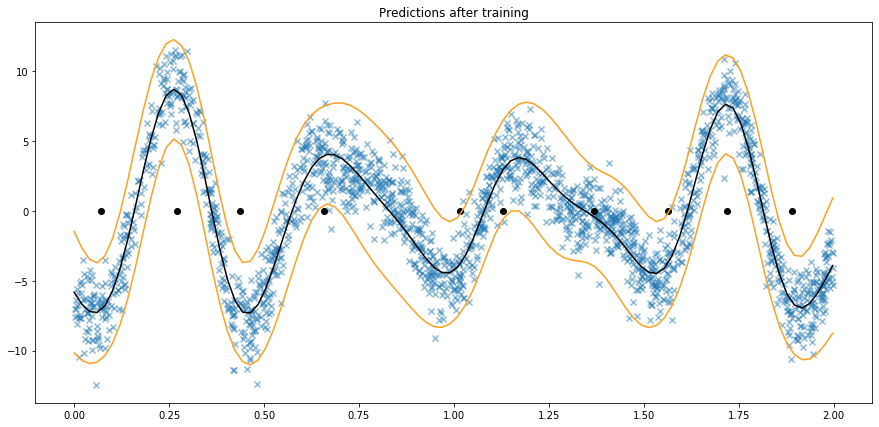

In [15]:
plot_model(m_init, X_batched[0], Y_batched[0], "Predictions after training")

batch 1
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


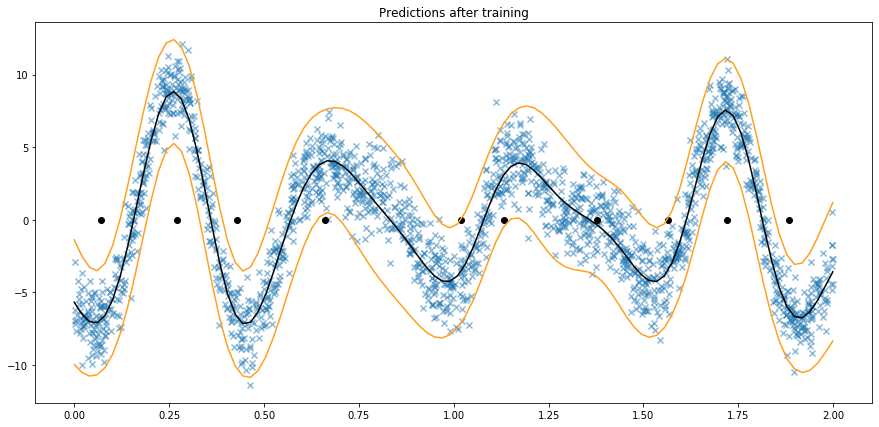

batch 2
batch 3


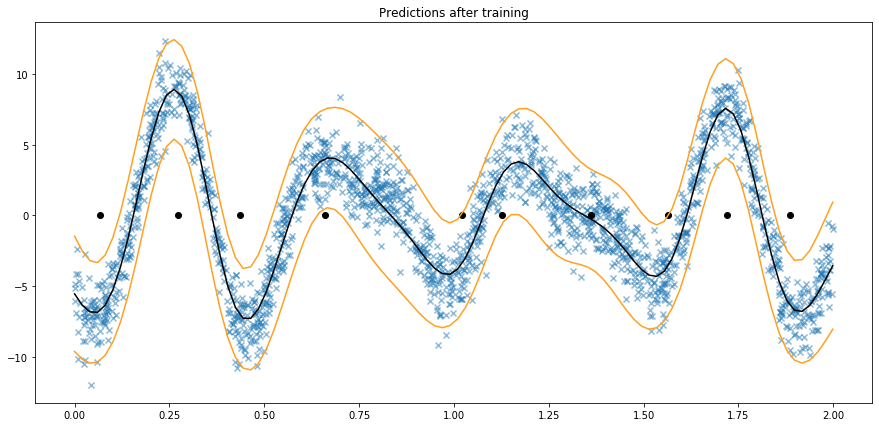

batch 4
batch 5


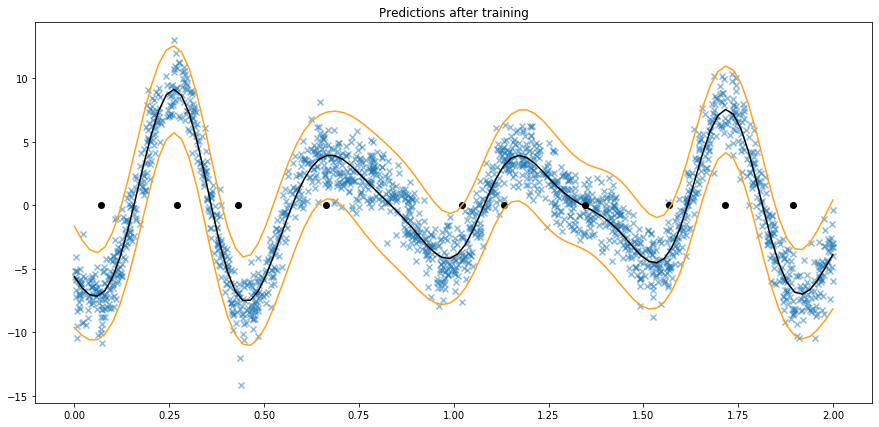

batch 6
batch 7


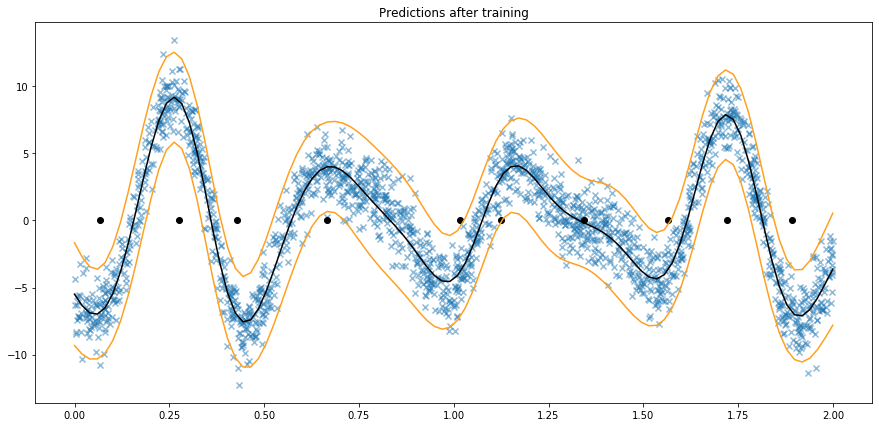

batch 8
batch 9


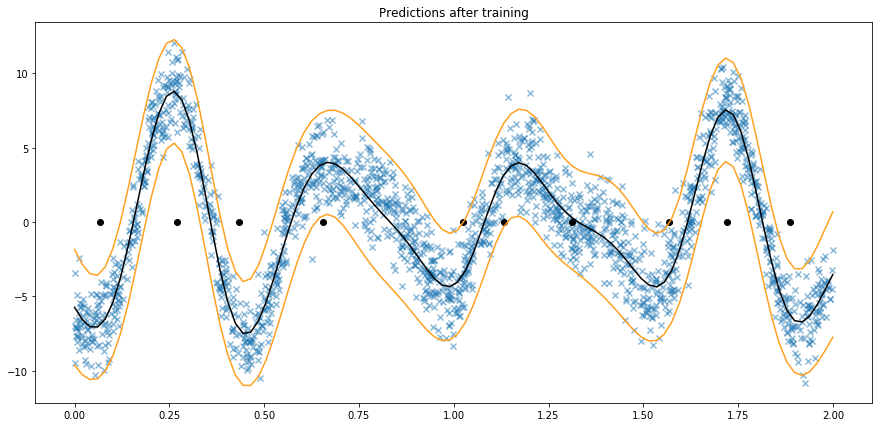

In [16]:
m_old = m_init
models = []
for i in range(1,10):
        print("batch {}".format(i))
        m_new = build_kernel(m_old, 0)
        data_new = (X_batched[i],Y_batched[i])
        Zold = m_old.inducing_variable.Z.numpy()
        Znew = m_new.inducing_variable.Z.numpy()
              
        step, Lc, KL = run_continuous_opt(m_old,m_new,data_new,Znew,Zold,maxiter=5000)
        
        if i%2 == 1:
            plot_model(m_new, X_batched[i], Y_batched[i], "Predictions after training").show()
            
        models.append([m_new,step,Lc,KL])
        
        m_old = m_new

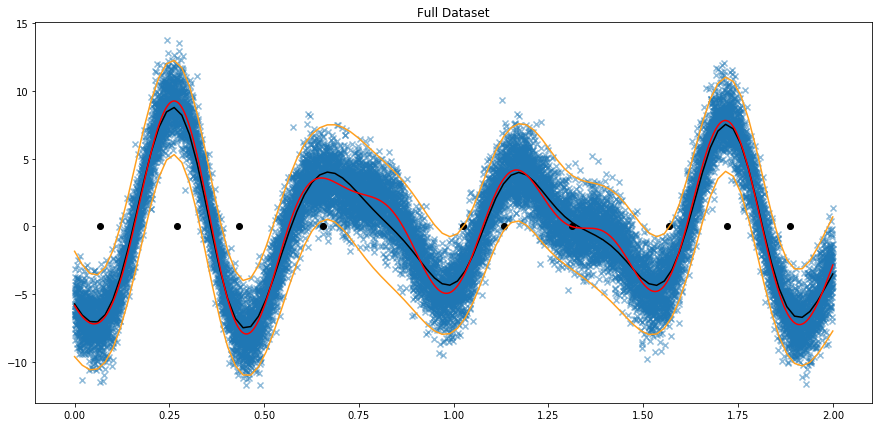

In [27]:
plot_model(models[8][0],X,Y,"Full Dataset")
plt.plot(Xt, true_f(Xt), c="r")

In [28]:
Xt = np.linspace(0, max(X[:,0]), 100)[:, None]
Yt, _ = models[8][0].predict_y(Xt)
trueY = true_f(Xt)
RMSE = np.sqrt((1/100)*(np.mean((trueY-Yt)**2)))
RMSE

0.04371570995905199

In [53]:
Lc =[]
for i in range(len(models)):
    for j in range(len(models[0][2])):
               Lc.append(models[i][2][j].numpy()[0])

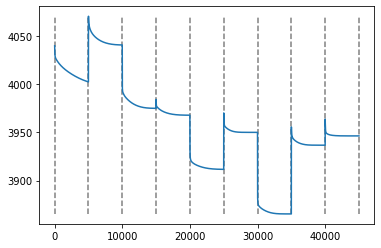

In [54]:
plt.plot(np.arange(5000*9)[::10], Lc)
batch = [i*5000 for i in range(10)]
plt.vlines(batch,np.min(Lc),np.max(Lc), linestyles='dashed', alpha=0.5)

Questions:

Where do we place the points? (M-DPP?)

One point at a time?
 - Make large synthetic dataset
 - Split in 2, first half is 'existing data', second streamed in batches
 - Reduce batch size, see what happens
 
Can subset of inducing inputs be fixed and others optimized 

What inducing points should we keep?


In [1]:
Kff = get_Kuu(m_init, m_init.inducing_variable.Z, m_init.inducing_variable.Z)[0].numpy()
Kff

NameError: name 'get_Kuu' is not defined

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [32]:
len(Kff)

2000

In [10]:
import dppy
from dppy.finite_dpps import FiniteDPP

In [34]:
DPP = FiniteDPP('likelihood', **{'L': Kff+np.eye(len(Kff))*1e-6})
DPP.flush_samples()
DPP.sample_exact_k_dpp(size=10)
ind = DPP.list_of_samples[0]

In [35]:
ind

[1597, 451, 900, 49, 1587, 1126, 273, 544, 117, 1380]

In [36]:
X_batched[1][ind,:]

array([[0.40530017],
       [0.952539  ],
       [0.16482049],
       [0.53018298],
       [0.89727732],
       [1.48867102],
       [1.29034847],
       [1.21786139],
       [1.68336673],
       [0.7894338 ]])

In [265]:
np.log(2000)

7.600902459542082

In [266]:
models[0][0].Ntotal = gpflow.Parameter(2000)                      

In [1]:
models[0][0]

NameError: name 'models' is not defined

In [1]:
!pip install transformers==3.1.0
#!pip install tensorflow_hub

  Using cached transformers-3.1.0-py3-none-any.whl (884 kB)
  Using cached sentencepiece-0.1.95-cp37-cp37m-win_amd64.whl (1.2 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.1.1
    Uninstalling transformers-4.1.1:
      Successfully uninstalled transformers-4.1.1


In [21]:
import tensorflow_hub as hub
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, TFBertForPreTraining

In [3]:
bert = hub.load('https://tfhub.dev/google/experts/bert/wiki_books/sst2/2')

INFO:absl:Using C:\Users\ac1dmrx\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2'.
INFO:absl:Downloading https://tfhub.dev/google/experts/bert/wiki_books/sst2/2: 130.00MB
INFO:absl:Downloading https://tfhub.dev/google/experts/bert/wiki_books/sst2/2: 260.00MB
INFO:absl:Downloading https://tfhub.dev/google/experts/bert/wiki_books/sst2/2: 390.00MB
INFO:absl:Downloaded https://tfhub.dev/google/experts/bert/wiki_books/sst2/2, Total size: 425.70MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2'.


In [21]:
bert = tf.keras.Model([hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/sst2/2')])
bert.fit()

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [23]:
model = TFBertForPreTraining()

TypeError: __init__() missing 1 required positional argument: 'config'

In [16]:
test = TFBertForPreTraining.from_pretrained('bert-base-uncased')

All model checkpoint weights were used when initializing TFBertForPreTraining.

All the weights of TFBertForPreTraining were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForPreTraining for predictions without further training.


In [3]:
from tf.keras.utils.vis_utils import plot_model

ModuleNotFoundError: No module named 'tf'

In [13]:
tf.keras.utils.plot_model(test)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [5]:
!pip install pydot graphviz

In [11]:
import pydot
import graphviz

In [17]:
test.summary()

Model: "tf_bert_for_pre_training"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
nsp___cls (TFBertNSPHead)    multiple                  1538      
_________________________________________________________________
mlm___cls (TFBertMLMHead)    multiple                  24459834  
Total params: 110,106,428
Trainable params: 110,106,428
Non-trainable params: 0
_________________________________________________________________


In [23]:
from transformers import TFTrainer

In [25]:
test.loss()

AttributeError: 'TFBertForPreTraining' object has no attribute 'loss'